In [1]:
#!rm -r AI2022MA/
#!git clone https://github.com/UmbertoJr/AI2022MA.git &> /dev/null

In [2]:
# Imports

from AI2022MA.IO_manager.io_tsp import TSP_Instance_Creator
# if you are running from your local remove the prefix AI2020 (comment the previous line and uncomment the following line)
#from IO_manager.io_tsp import TSP_Instance_Creator

ic = TSP_Instance_Creator("standard", 'eil76.tsp')
ic.print_info()
#ic.plot_data()

name: eil76
nPoints: 76
best_sol: 538.0


In [3]:
%matplotlib notebook
import time
from IPython import display
from matplotlib import pyplot as plt


def plot_tour(instance, tour, ant):
    """plot iterativerly the tour for that ant

    Args:
        instance (TSP_Instance_Creator): TSP problem
        tour (list): tour of the ant
        ant (int): ant number
    """
    plt.figure(figsize=(8, 8))
    plt.grid()
    plt.title(f"Tour Ant # {ant}")
    plt.scatter(instance.points[:, 1], instance.points[:, 2])
    for t in range(len(tour)-1):
        xy1, xy2 = tour[t], tour[t+1]
        plt.plot([instance.points[xy1, 1], instance.points[xy2, 1]], [
                 instance.points[xy1, 2], instance.points[xy2, 2]], color="blue")
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.1)

In [86]:
import numpy as np
import random
from AI2022MA.solvers import local_search
from AI2022MA.solvers.constructive_algorithms import nn
from AI2022MA.solvers.local_search import TwoOpt
from threading import Thread
from time import sleep

class TabuSearch():
    def __init__(self, instance, time_expiration):
        self.instance=instance
        self.n = instance.nPoints
        self.dist_mat = instance.dist_matrix
        self.s0, self.L_nn = nn(instance.dist_matrix,
                            starting_node=np.random.choice(self.n))
        self.sBest= self.s0
        #random.shuffle(self.sBest)
        print("initial len: ", self.compute_distance_tour(self.sBest))
        self.Candidate= self.sBest
        print(self.Candidate)
        self.tabu_List=[]
        self.size_list= 100
        self.stop_after_secs =time_expiration
        
        self.sol_length =0. 
        self.list_val =[]
        self.list_val2 =[]
    
    def compute_distance_tour(self, sol):
        length_tour =0.
        for i in range(len(sol)-1):
            length_tour+=self.dist_mat[sol[i], sol[i+1]]
        length_tour+=self.dist_mat[sol[-1], sol[0]]
        return length_tour
    
    def check_tabuList(self, move):
        #if(move in self.tabu_List):
            #print(f"invalid move in tabu list: ")
        return move in self.tabu_List
    
    def getNeightbors(self, Candidate):
        sNeighbors=[]
        

        for _ in range(10):
            
            '''
            random1 = np.random.randint(low=0, high=(len(Candidate_copy)))
            random2 = np.random.randint(low=0, high=(len(Candidate_copy)))
            random3 = np.random.randint(low=0, high=(len(Candidate_copy)))
            random4 = np.random.randint(low=0, high=(len(Candidate_copy)))
            while(random1==random2 or random3 == random4):
                random1 = np.random.randint(low=0, high=(len(Candidate_copy)))
                random2 = np.random.randint(low=0, high=(len(Candidate_copy)))
                random3 = np.random.randint(low=0, high=(len(Candidate_copy)))
                random4 = np.random.randint(low=0, high=(len(Candidate_copy)))
            
            #print("random 1", random1, "random2", random2)
            tmp = Candidate_copy[random1]
            Candidate_copy[random1] = Candidate_copy[random2]
            Candidate_copy[random2] = tmp
            tmp = Candidate_copy[random3]
            Candidate_copy[random3] = Candidate_copy[random4]
            Candidate_copy[random3] = tmp'''
            length = self.compute_distance_tour(Candidate)
            #print(type(Candidate))
            
            Candidate = next(TwoOpt.local_search(Candidate, length, self.dist_mat))[0]
            if(isinstance(Candidate, np.ndarray )):
                Candidate =Candidate.tolist()
            #print("solution changed: ", Candidate_copy)
            #print(Candidate_copy == self.Candidate)
            #print("Cost :", self.compute_distance_tour(Candidate_copy))
            #print(f"swaped city {city1} with city {city2}")
            sNeighbors.append(Candidate)
        return sNeighbors
        
    def solve(self):
        time_elapsing = Thread(target=lambda: sleep(self.stop_after_secs))
        time_elapsing.start()
        self.it =0
        self.it2=0
        np.random.seed(0)
        best_sCandidate = self.Candidate
        while(time_elapsing.is_alive()):
            fitness_sBest = self.compute_distance_tour(self.sBest)
            if(self.it%50000==0 and self.it!=0):
                print(f"iteration # {self.it}")
            self.it += 1
            #print(type(best_sCandidate))
            sNeighborhood = self.getNeightbors(best_sCandidate)
            best_sCandidate = sNeighborhood[0]
            #random.shuffle(best_sCandidate)
            
            for sCandidate in sNeighborhood:
                #print(sCandidate==best_sCandidate)
                fitness_n = self.compute_distance_tour(sCandidate)
                self.it2+=1
                self.list_val.append(self.compute_distance_tour(self.sBest))
                fitness_bestCandidate=self.compute_distance_tour(best_sCandidate)
                self.list_val2.append(fitness_bestCandidate)
                
                if((not self.check_tabuList( sCandidate)) and fitness_n < fitness_bestCandidate):
                    best_sCandidate= sCandidate
                if(fitness_bestCandidate<fitness_sBest):
                    #print("best solution found")
                    self.sBest = best_sCandidate
                
                
                #if(best_sCandidate==100000000):
                 #   best_sCandidate= sCandidate
                 #   continue
                
            self.tabu_List.append(best_sCandidate)
            
            if(len(self.tabu_List)>self.size_list):
                self.tabu_List.remove(self.tabu_List[0])
            #self.Candidate=best_sCandidate
        self.sol_length = self.compute_distance_tour(self.sBest)
        return self.sBest

In [87]:
tab_search = TabuSearch(ic, 10)
sol = tab_search.solve()
print(f"solution proposed by NN: {tab_search.s0}")
print("solution by Tabu Search:", sol)
print(f"len NN: {tab_search.compute_distance_tour(tab_search.s0)}, len tabu_Search: {tab_search.sol_length}")


initial len:  673.0
[16, 50, 5, 67, 74, 75, 66, 33, 45, 51, 26, 44, 28, 47, 46, 35, 68, 70, 59, 69, 19, 36, 4, 14, 56, 12, 53, 18, 34, 7, 6, 52, 13, 10, 65, 64, 37, 9, 57, 71, 38, 8, 31, 43, 2, 15, 62, 32, 72, 0, 42, 40, 41, 63, 21, 61, 27, 73, 1, 29, 3, 25, 11, 39, 49, 17, 24, 54, 30, 23, 48, 22, 55, 60, 20, 58]
solution proposed by NN: [16, 50, 5, 67, 74, 75, 66, 33, 45, 51, 26, 44, 28, 47, 46, 35, 68, 70, 59, 69, 19, 36, 4, 14, 56, 12, 53, 18, 34, 7, 6, 52, 13, 10, 65, 64, 37, 9, 57, 71, 38, 8, 31, 43, 2, 15, 62, 32, 72, 0, 42, 40, 41, 63, 21, 61, 27, 73, 1, 29, 3, 25, 11, 39, 49, 17, 24, 54, 30, 23, 48, 22, 55, 60, 20, 58]
solution by Tabu Search: [24, 54, 17, 49, 31, 43, 2, 39, 16, 50, 5, 67, 1, 61, 21, 42, 0, 72, 32, 62, 15, 48, 23, 22, 55, 40, 41, 63, 60, 20, 27, 73, 29, 3, 74, 75, 66, 25, 11, 6, 34, 7, 45, 33, 51, 26, 44, 28, 47, 46, 35, 68, 70, 59, 69, 19, 36, 4, 14, 56, 12, 53, 18, 52, 13, 58, 10, 65, 64, 37, 9, 30, 57, 71, 38, 8]
len NN: 673.0, len tabu_Search: 569.0


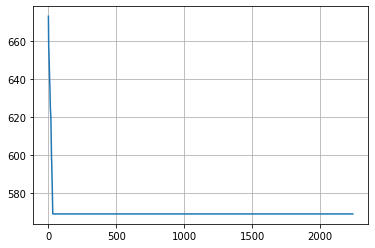

In [88]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(list(range(tab_search.it2)), tab_search.list_val)
plt.grid()
plt.show()